---
title: Designing data for development
author: Brandon Rundquist
slug: devdata
aliases:
  - /articles/devdata
author_title: bswrundquist
categories:
  - sampling
  - recommendation
subtitle: ''
summary: ''
execute:
  freeze: auto
  cache: true
  warning: false
  message: false
  echo: true
code-fold: false
code-annotations: below
---


Training a model requires data. And in the era of big data, deep learning, and large compute the data sets have become unwieldy and cost prohibitive.

The first step in creating a model is to create a dataset that is workable. A workable dataset has the same shape and type as the original dataset but is a fraction of the size. Having a workable dataset is important because it allows for quicker development and testing.

But that is only half the problem when it comes to modeling. The other half is having a representative dataset. A representative dataset is a dataset that has the same distribution as the original dataset. This is important because it allows for the model to be trained on a dataset that is similar to the original dataset. The model will be more accurate and reliable if it is trained on a representative dataset and more indicative of the results we would get from using the entire dataset.

In this post we will go over what it means to be a **workable** dataset and a **representative** dataset to optimize the development process for creating a model.

## Workable vs representative dataset

For illustrative purposes we will look at the extreme cases of what it means to be a workable and representative dataset.

The most workable dataset is a dataset that contains only one row. This dataset is workable because it is small and easy to work with. But it is not representative because it does not contain enough information to be useful.

The most representative dataset is a dataset that contains all the rows of the original dataset. This dataset is representative because it contains all the information of the original dataset. But it is not workable because it is too large to work with.

The goal is to find a dataset that is both workable and representative. This dataset will be small enough to work with but contain enough information to be useful.

# Getting started

To get started we will be using the Ratebeer dataset. The Ratebeer dataset is a dataset of beer reviews that contains information about the beer, the brewery, and the user who reviewed the beer. The dataset is large and contains over 1 million reviews. The Ratebeer dataset is for evaluating recommendation models. The dataset is a good candidate for seeing the importance of creating a workable and representative dataset since it is too large for iterative work and has associated papers that can help guide us in creating a representative dataset.

The model we will use for fitting a recommendation model is an SVD model. The SVD model is a matrix factorization model that is used for collaborative filtering. The SVD model is a good candidate for this dataset because it is a simple model that can be trained on a large dataset and is easy to interpret.

The problem is that it grows in time complexity as the dataset grows. A way to measure time complexity is a term called [Big O notation](https://en.wikipedia.org/wiki/Big_O_notation). This is a way to measure how the time it takes to run an algorithm grows as the size of the input grows. The SVD model has a time complexity of $O(mn min(m,n))$ where m is the number of users and n is the number of items. But m*n would be for a fully dense matrix and in the case of the Ratebeer dataset it is sparse. This means we can approximate the time complexity to be $O(r min(m,n))$ where r is the number of ratings which will be less than m\*n. Therefore we need to focus on lowering the number of reviews we have in the dataset to reduce our time complexity.

Fitting the model will be done with the Python library [Surprise](https://surprise.readthedocs.io/en/stable/index.html). Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. The library is built on top of SciPy and NumPy and is easy to use and understand.

# The dataset

In [ ]:

# # Open the 'ratebeer.json' file in read mode
# with open(, 'r') as file:
#     # Read and parse each line as JSON
#     for line in file:
#         try:
#             data = json.loads(line)
#             # Process the JSON object (data) as needed
#             print(data)
#         except json.JSONDecodeError as e:
#             print(f"Error decoding JSON: {e}")
#             break

# Fitting the model with all the data

To start we will fit the model with all the data. This will give us a baseline to compare our workable and representative datasets to. We will use the `SVD` model from the `surprise` library to fit the model. The `SVD` model is a matrix factorization model that is used for collaborative filtering. The `SVD` model is a good candidate for this dataset because it is a simple model that can be trained on a large dataset and is easy to interpret.

// TODO: Add code to fit the model with all the data
// TODO: Add code to evaluate the model
// TODO: Add code to show the results
// TODO: Add code to show the time it took to fit the model

In [49]:
import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

FULL_DATASET_PATH = "~/data/ratebeer_sample.parquet"

df = pd.read_parquet(FULL_DATASET_PATH)
df.head()
df['review'] = df['review/overall'].apply(lambda x: int(x.split("/")[0])) / 4
df.columns

Index(['beer/name', 'beer/beerId', 'beer/brewerId', 'beer/ABV', 'beer/style',
       'review/appearance', 'review/aroma', 'review/palate', 'review/taste',
       'review/overall', 'review/time', 'review/profileName', 'review/text',
       'review'],
      dtype='object')

In [63]:
import numpy as np
df.head(), 

number_of_test_users = df['review/profileName'].nunique() // 10
test_users = np.random.choice(df['review/profileName'].unique(), number_of_test_users, replace=False)
train_users = [user for user in df['review/profileName'].unique() if user not in test_users]
test_df = df[df['review/profileName'].isin(test_users)]
full_train_df = df[df['review/profileName'].isin(train_users)]


In [76]:

def fit_rec_sys(train_df, test_df=test_df):
    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(train_df[['beer/name', 'review/profileName', 'review']], reader)
    test_data = Dataset.load_from_df(test_df[['beer/name', 'review/profileName', 'review']], reader)
    algo = SVD()
    algo.fit(train_data.build_full_trainset())
    predictions = algo.test(test_data.build_full_trainset().build_testset())
    return predictions

def get_rmse(predictions):
    return accuracy.rmse(predictions)

full_dataset_predictions = fit_rec_sys(full_train_df)
full_dataset_rmse = get_rmse(full_dataset_predictions)
print(full_dataset_rmse), len(full_dataset_predictions)

RMSE: 0.7019
0.7019169790334411


(None, 9035)

:::{.callout-info}
We will keep the test data seperate from how we sample the training data. Seeing how the different sampling methods affect the model is important to see how it performs on unseen data.
:::

In [79]:
test_df['beer/name'].nunique(), full_train_df['beer/name'].nunique(), df.shape

(5872, 27564, (100000, 14))

In [48]:
accuracy.rmse(predictions, verbose=True)

RMSE: 2.6808


2.680801491709675

In [20]:
accuracy.rmse(predictions, verbose=True)

RMSE: 8.8703


8.870312109201794

# Creating a workable dataset

Our goal now is to create a workable dataset that can reduces the time complexity of the model. The first approach is to take a random sample of the dataset. This is going to save the least amount of information from the original dataset but it will allow for developing right out of the gate.

We saw previously the most workable dataset is 1 sample. But that is not useful. The better first approach is to take a random sample of the dataset whose size is determined by compute and time constraints. This is going to save the least amount of information from the original dataset but it will allow for developing right out of the gate.

In [39]:
sampled_df = df.sample(frac=0.1)
sampled_df.shape, sampled_df.columns

((10000, 14),
 Index(['beer/name', 'beer/beerId', 'beer/brewerId', 'beer/ABV', 'beer/style',
        'review/appearance', 'review/aroma', 'review/palate', 'review/taste',
        'review/overall', 'review/time', 'review/profileName', 'review/text',
        'review'],
       dtype='object'))

Text(0.5, 0, 'Rating')

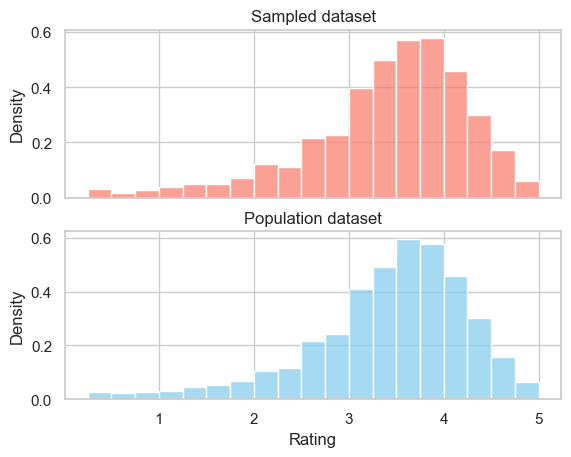

In [42]:
#| echo: false
import seaborn as sns
import matplotlib.pyplot as plt
bin_edges = sampled_df.review.sort_values().unique()
sns.set(style="whitegrid")
f, axarr = plt.subplots(2, sharex=True)
sns.histplot(x=sampled_df.review.astype(float), bins=bin_edges, kde=False, color='salmon', label='Dataset 2', stat='density', common_bins=True, ax=axarr[0])
axarr[0].set_title('Sampled dataset')
sns.histplot(x=df.review, bins=bin_edges, ax=axarr[1], kde=False, color='skyblue', label='Dataset 1', stat='density', common_bins=True)
axarr[1].set_title('Population dataset')
axarr[1].set_xlabel('Rating')

A visual inspection shows that these two datasets have similar distributions at a fractions of the size.


In [ ]:
#| echo: false
# import time

# start_time = time.time()
# _ = [ratings_sampled_df.std() for _ in range(100)]
# sampled_std_time = round(time.time() - start_time, 2)

# start_time = time.time()
# _ = [ratings_sampled_df.mean() for _ in range(100)]
# sampled_mean_time = round(time.time() - start_time, 2)

# start_time = time.time()
# _ = [ratings_df.std() for _ in range(100)]
# population_std_time = round(time.time() - start_time, 2)

# start_time = time.time()
# _ = [ratings_df.mean() for _ in range(100)]
# population_mean_time = round(time.time() - start_time, 2)
#f"{sampled_mean_time:.2f}"<

<table class="table table-striped table-hover">
  <caption>As described in the section above, Quarto tables are great.</caption>
  <thead class="table-light">
    <tr>
      <th scope="col">Dataset</th>
      <th scope="col">Mean time</th>
      <th scope="col">Std time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Population</td>
      <td>python population_mean_time</td>
      <td>python population_std_time</td>
    </tr>
    <tr>
      <td>Sampled</td>
      <td>python sampled_mean_time</td>
      <td>python sampled_std_time</td>
    </tr>
  </tbody>
</table>


<!-- We get a close to {python} round(population_mean_time / sampled_mean_time,2) speed up time in calculating the mean and a {python} round(population_std_time / sampled_std_time, 2)`k speed up time for the standard deviation.
No surprise that shrinking the dataset will make an algorithm faster but seeing the magnitude helps understand that at a per developer hour cost this is going to help scale efficiently. -->
We now have a *workable* dataset that will allow us to start developing code that against the data. Now as we develop code we have a new auxillary goal to refine our process in creating our development dataset to be more representative.


## Digging in

To this point we have not considered the timestamp feature. Everytime a user gives a movie a rating their is an associated timestamp. 
The users behavior over time is of interest to us since we were told that it is likely to change overtime.
Looking at what we have vs

```python
#| echo: false
# sampled_userid_vals = ratings_sampled_df.groupby('userId').size().describe()
# population_userid_vals = ratings_df.groupby('userId').size().describe()
```



!!! Sampled df hist is fairly similar which is a plus! Then say you want to do a time series per user



## TODOs

- Get by UserID since they have many reviews per
- Up quality of val dataset by getting having hold out movies
    - show how quicker dev loop time allows for easier to find this


## Goal

- Reduce constraints to data
    - Remove PHI/PII


## Introduction

Hey there, tech enthusiast! Have you ever wished you could automate those repetitive tasks and make your workflow smoother? If so, you're in for a treat! Today, we're exploring Make—a tool that's been a staple for developers for decades. Whether you're an experienced coder or just starting out, Make is about to become your new favorite tool.

Let’s take a quick trip back in time. Imagine it’s the 1970s, and Make emerges as a game-changer for developers, simplifying complex tasks and automating workflows. Fast forward to today, and Make is still going strong, proving its reliability and utility. It’s like a classic tool that never goes out of style—dependable and effective.

But what does Make actually do? In simple terms, Make acts like your project manager, ensuring tasks are executed in the right order. It reads a Makefile that lists jobs and their dependencies, essentially a to-do list for your project with superpowers.

Now, let’s bring Docker into the mix. Docker allows us to create portable containers that package our applications and their dependencies, ensuring consistency across different environments. Imagine having a perfect setup for your code every time, without the "it works on my machine" issues.

In this blog post, we’re combining the power of Make and Docker to streamline job management in your repository. We’ll show you how to run a Python script inside a Docker container, making your workflow cleaner and more efficient. Whether you’re automating data processing or running machine learning tasks, you’re in the right place.

By the end of this post, you’ll have the tools to turn your project’s to-do list into a well-oiled machine, thanks to Make and Docker. Let’s dive in and make automation simple and effective! 


To create a model requires data, compute, and storage. The model is a function of these three things.
